In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [4]:
pjme = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Measles/benin.csv', index_col=[0], parse_dates=[0])

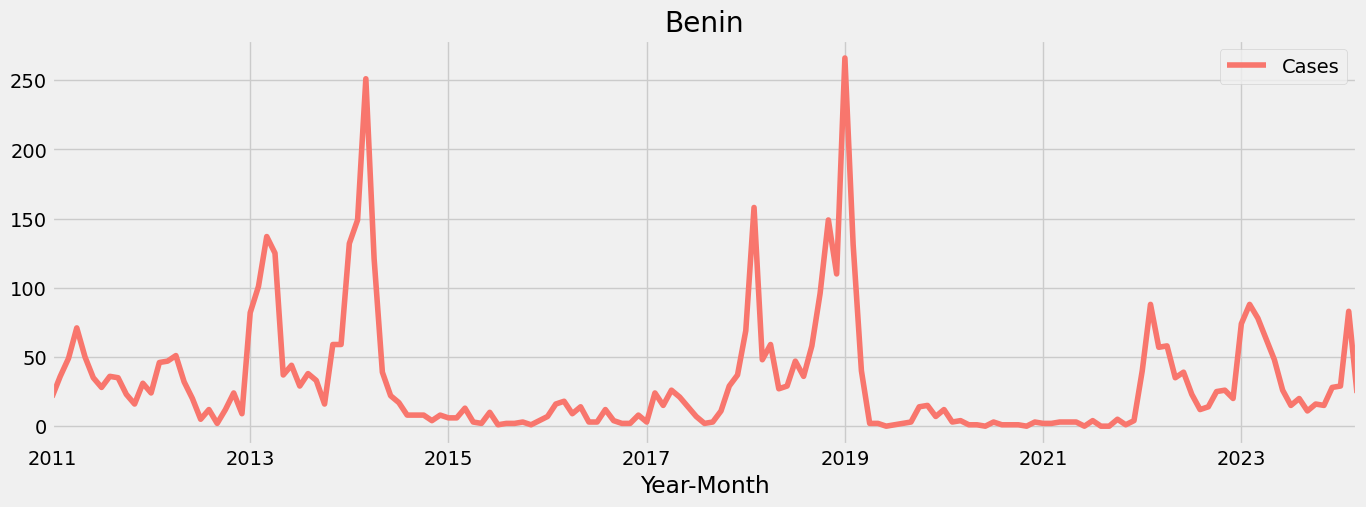

In [5]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(figsize=(15,5), color=color_pal[0], title='Benin')

In [6]:
split_date = '01-March-2023'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [7]:
len(pjme_test)

12

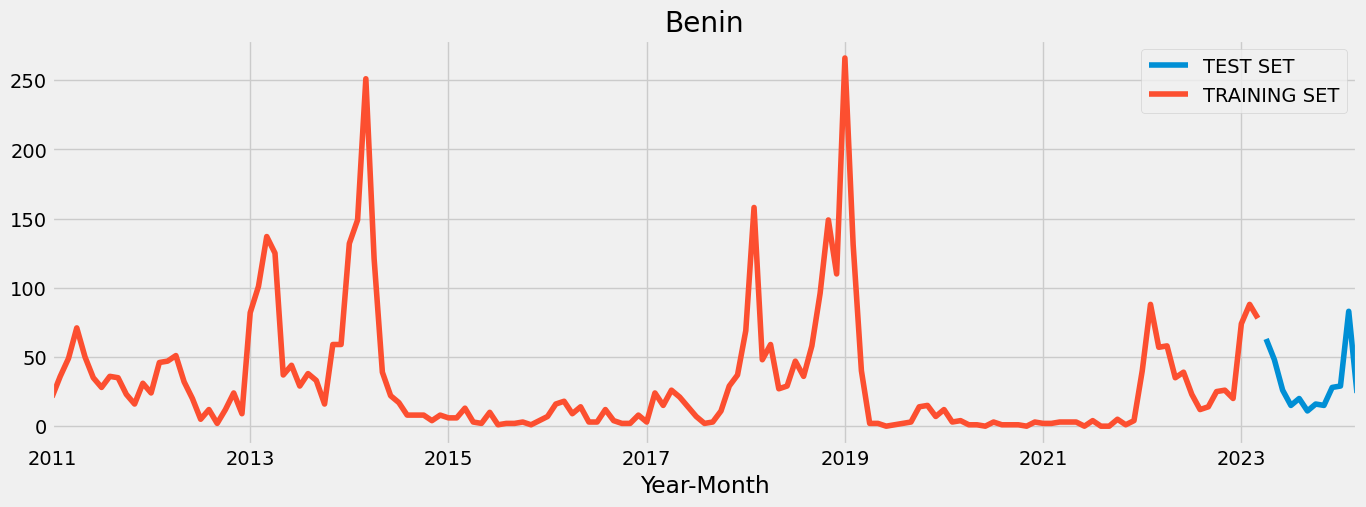

In [8]:
_ = pjme_test \
    .rename(columns={'Cases': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Cases': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Benin')

In [9]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
X_train, y_train = create_features(pjme_train, label='Cases')
X_test, y_test = create_features(pjme_test, label='Cases')

In [11]:
reg = xgb.XGBRegressor(n_estimators=17, max_depth=7, eta=0.3, subsample=0.3, colsample_bytree=0.8)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=20,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:38.51436	validation_1-rmse:21.10352
[1]	validation_0-rmse:35.90239	validation_1-rmse:19.37647
[2]	validation_0-rmse:32.73199	validation_1-rmse:17.52418
[3]	validation_0-rmse:30.64933	validation_1-rmse:16.18892
[4]	validation_0-rmse:28.02497	validation_1-rmse:15.31855
[5]	validation_0-rmse:27.54599	validation_1-rmse:14.85746
[6]	validation_0-rmse:27.39178	validation_1-rmse:14.43816
[7]	validation_0-rmse:27.45452	validation_1-rmse:12.95986
[8]	validation_0-rmse:27.31597	validation_1-rmse:12.68745
[9]	validation_0-rmse:27.29123	validation_1-rmse:12.10907
[10]	validation_0-rmse:27.28664	validation_1-rmse:12.13056
[11]	validation_0-rmse:27.33318	validation_1-rmse:11.02364
[12]	validation_0-rmse:24.31131	validation_1-rmse:10.62666
[13]	validation_0-rmse:24.43543	validation_1-rmse:10.50635
[14]	validation_0-rmse:23.94218	validation_1-rmse:9.66735
[15]	validation_0-rmse:23.65202	validation_1-rmse:10.33274
[16]	validation_0-rmse:23.65895	validation_1-rmse:8.21043


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=17,
             n_jobs=None, num_parallel_tree=None, ...)

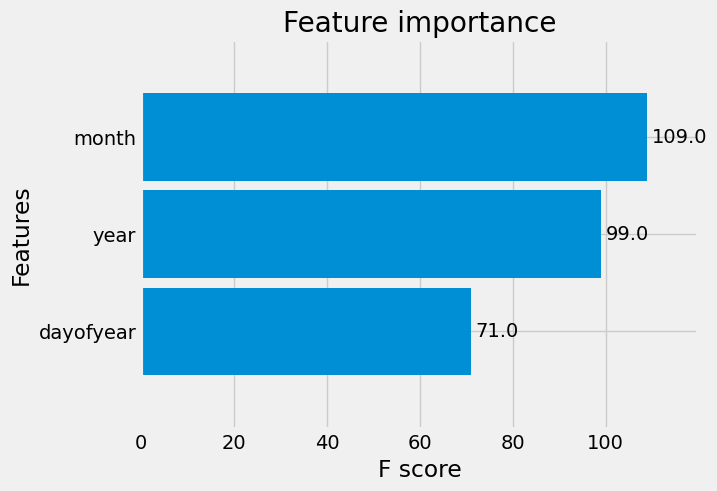

In [12]:
_ = plot_importance(reg, height=0.9)

In [13]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

In [14]:
pjme_test['MW_Prediction']

Year-Month
2023-04-01    47.700729
2023-05-01    33.019440
2023-06-01    29.664467
2023-07-01    16.152958
2023-08-01    16.499966
2023-09-01    19.094681
2023-10-01    26.030125
2023-11-01    23.567795
2023-12-01    29.049746
2024-01-01    37.887230
2024-02-01    81.555893
2024-03-01    25.318027
Name: MW_Prediction, dtype: float32

In [16]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(pjme_test['Cases'],pjme_test['MW_Prediction']))
#print('Test RMSE: %.4f' % error)

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(pjme_test['Cases'],pjme_test['MW_Prediction'])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
#print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(pjme_test['Cases'],pjme_test['MW_Prediction'])
#print("Mean Squared Logarithmic Error (MSLE):", msle)

from sklearn.metrics import mean_absolute_percentage_error
#print('Mean Absolute Percentage Error (MAPE):',mean_absolute_percentage_error(test_data_pr['y'],prophet_pred['Pred']))

print('RMSE: %.2f' % error)
print(f"MAPE: {mape:.2f}%")
print('MAE:  %.2f' % mae)
print('MSLE: %.2f' % msle)

RMSE: 8.21
MAPE: 27.48%
MAE:  6.50
MSLE: 0.08


In [17]:
pjme_test['Cases']

Year-Month
2023-04-01    63
2023-05-01    48
2023-06-01    26
2023-07-01    15
2023-08-01    20
2023-09-01    11
2023-10-01    16
2023-11-01    15
2023-12-01    28
2024-01-01    29
2024-02-01    83
2024-03-01    24
Name: Cases, dtype: int64

In [18]:
pjme.index[-1]

Timestamp('2024-03-01 00:00:00')

In [19]:
# Generate dates for the next 6 months
last_date = pjme.index[-1]  # Get the last date in the dataset
next_dates = pd.date_range(start=last_date, periods=7, freq='M')[1:]  # Generate next 6 months dates

# Create features for the next 6 months
next_features = create_features(pd.DataFrame(index=next_dates))

# Make predictions for the next 6 months
next_predictions = reg.predict(next_features)

# Create a DataFrame for the predictions
future_predictions = pd.DataFrame({
    'Date': next_dates,
    'MW_Prediction': next_predictions
})

future_predictions.set_index('Date', inplace=True)

future_predictions

,MW_Prediction
Date,
2024-04-30,22.713968
2024-05-31,28.434517
2024-06-30,26.864902
2024-07-31,11.873571
2024-08-31,16.638006
2024-09-30,15.570810


In [20]:
asd=pjme_test['Cases']

In [21]:
asd.loc['2024-04-01'] = 23
asd.loc['2024-05-01'] = 28
asd.loc['2024-06-01'] = 27
asd.loc['2024-07-01'] = 12
asd.loc['2024-08-01'] = 17
asd.loc['2024-09-01'] = 16

In [22]:
asd = asd.iloc[12:]

In [23]:
asd

Year-Month
2024-04-01    23
2024-05-01    28
2024-06-01    27
2024-07-01    12
2024-08-01    17
2024-09-01    16
Name: Cases, dtype: int64

<ipython-input-24-6e0f2e801c5c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pjme_test['MW_Prediction']


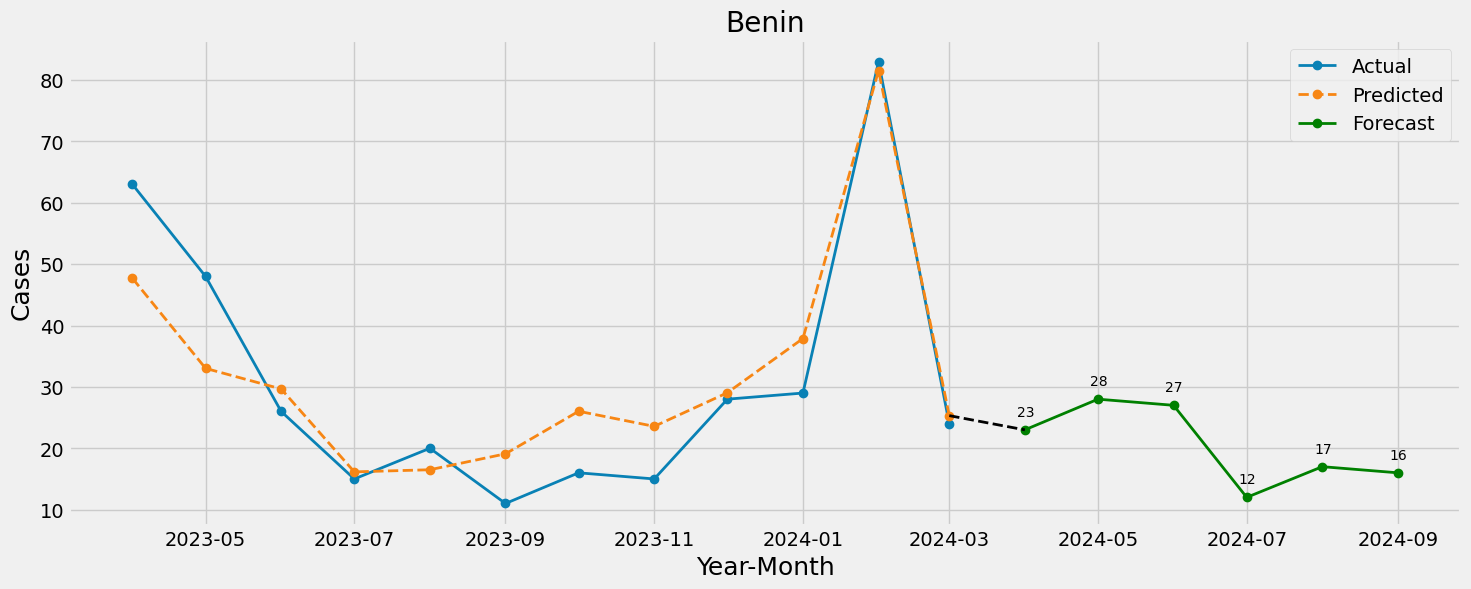

In [24]:
import matplotlib.pyplot as plt

# Assuming 'asd' contains your forecasted values
forecasting = asd
valid = pjme[147:]
valid['Predictions'] = pjme_test['MW_Prediction']
# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Benin')
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Cases', fontsize=18)

# Plot actual cases
plt.plot(valid['Cases'], color='#0981b5', marker='o', linewidth=2, label='Actual')

# Plot predicted cases
plt.plot(valid['Predictions'], color='#f78614', marker='o', linestyle='--', linewidth=2, label='Predicted')

# Plot forecasted cases
plt.plot(forecasting.index, forecasting.values, color='green', marker='o', linewidth=2, label='Forecast')

# Dashed line connecting predicted and forecasted values
plt.plot([valid.index[-1], forecasting.index[0]], [valid['Predictions'].iloc[-1], forecasting.iloc[0]], 'k--', linewidth=2)

# Annotate forecasted values
for i, txt in enumerate(forecasting.values):
    plt.annotate(txt, (forecasting.index[i], txt), xytext=(-6, 10), textcoords='offset points', fontsize=10)

# Legend and display
plt.legend(loc='upper right')
plt.show()